## Objective
Train DL sorter
Recording --> DL detector --> DL sorter

## General setup

In [1]:
%load_ext autoreload

In [13]:
from random import randint
import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
from collections.abc import Iterable
import json

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [5]:
%autoreload 2
import data

In [169]:
class KilosortDLDataset(Dataset):
    def __init__(self, rec_path, dl_detector_path,
                 sample_size=30):
        rec_path = Path(rec_path)
        # self.traces = np.load(rec_path / "traces.npy", mmap_mode="r")
        sorted = np.load(rec_path / "sorted.npz", allow_pickle=True)
        self.sorted = sorted
        
        dl_detector_path = Path(dl_detector_path)
        with open(dl_detector_path / "init_dict.json", "r") as f:
            init_dict = json.load(f)
        self.model_front_buffer = init_dict["buffer_front_sample"]
    
        self.detector_outputs = np.load(dl_detector_path / "log/windows_200_120/outputs.npy", mmap_mode="r")
    
        self.sample_size = sample_size
        
        # self.noise_times = self.get_noise_times(0, self.detector_outputs.shape[1], sorted["spike_times"], 100, 100)
        # global Noise_times
        # Noise_times = self.noise_times
        
        self.noise_times = Noise_times

    def __len__(self):
        return 2
    
    def __getitem__(self, idx):
        if idx % 2 == 0:  # Spike
            # unit = np.random.choice(self.sorted["units"])
            unit = self.sorted["units"][0]
            # frame = np.random.choice(unit.frame)
            frame = self.sample_size//2
            label = 0
        else:  # Noise
            frame = self.noise_times[0]
            label = 1
            
        window = self.detector_outputs[:, frame-self.sample_size//2:frame+self.sample_size//2]
        window = torch.tensor(window, dtype=torch.float32)
        window = torch.sigmoid(window)
        return window[None, :, :], torch.tensor([label]), frame
        
    def rec_frame_to_detector_frame(self, frame):
        return frame - self.model_front_buffer
    
    def get_noise_times(self, start, total_duration, spike_times, n_before, n_after):
        """
        Get the timepoints in a recording where there are no spikes, and there is enough
        space to extract a sample. A timepoint t will be returned as if it will be used to
        extract a sample corresponding to the interval [t, t+sample_size)

        A timepoint t from the recording will be returned if at least one of the following
        conditions is met:
            1) There is a spike within the interval [t-(n_before + self.sample_size), t+n_after]
            2) t+sample_size > total_duration

        :param start: int
            Frame to start getting samples from recording
            I.e. if start=5, all samples before sample 5 will be disregarded
        :param total_duration: int
            Number of total samples in the recording
        :param spike_times: np.array
            Each element is a spike time (in samples)
        :param n_before: int
            Number of frames before spike location that contain remnants of spike
        :param n_after: int
            Number of frames after spike location that contain remnants of spike

        :return: non_spike_times: np.array
            Each element is a timepoint (in samples) that can be used to extract a sample
            from the raw recording
        """

        # Get all sample times
        sample_times = np.arange(start, total_duration - self.sample_size+1)

        # Convert spike times to detector output frames
        spike_times = self.rec_frame_to_detector_frame(spike_times)
        spike_times = spike_times[spike_times >= self.sample_size//2]

        # Get times that meet condition 1
        n_before += self.sample_size - 1
        # failed_times = [t for st in spike_times for t in range(st - n_before, st + n_after + 1)]
        failed_times = np.unique(spike_times - np.arange(-n_before, n_after+1)[:, None])
        return np.setdiff1d(sample_times, failed_times)
    
    def plot_detector_outputs(self, frame, n_before=15, n_after=15):
        frame = self.rec_frame_to_detector_frame(frame)
        window = self.sigmoid(self.detector_outputs[:, frame-n_before:frame+n_after])
        plt.plot(window.T)
        plt.show()        
    
    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

detector_dataset = KilosortDLDataset(
    rec_path="/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320",
    dl_detector_path="/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810"
)
detector_dataset[0]

(tensor([[[4.1660e-05, 2.3369e-05, 3.6765e-05,  ..., 4.8986e-06,
           5.2145e-06, 7.4113e-06],
          [5.2662e-05, 5.9209e-05, 3.8229e-05,  ..., 1.3007e-05,
           6.7481e-06, 3.6403e-06],
          [9.9729e-06, 4.9370e-06, 8.8011e-06,  ..., 2.7969e-05,
           1.8059e-05, 1.9223e-05],
          ...,
          [1.0051e-05, 7.8893e-06, 1.6964e-05,  ..., 6.2050e-05,
           7.0312e-05, 1.3552e-04],
          [1.6865e-04, 4.6011e-04, 2.9596e-04,  ..., 1.3603e-06,
           7.8893e-06, 3.6479e-05],
          [5.3911e-05, 5.5278e-04, 2.7587e-04,  ..., 8.8011e-06,
           8.2679e-06, 7.2964e-06]]]),
 tensor([0]),
 15)

In [171]:
from torch import nn

from tqdm import tqdm

class DLSorter(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv1d(384, 50, 3),
            nn.ReLU(),
            nn.Conv1d(50, 50, 3),
            nn.ReLU(),
            nn.Conv1d(50, 50, 3),
            nn.ReLU(),
            nn.Conv1d(50, 2, 3),
            nn.AvgPool1d(30-2*4),
            nn.Flatten()
        )
        # self.model = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(384*30, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 2)
        # )
        
        
        self.loss = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.parameters(), lr=3e-4)
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataset):
        for _ in tqdm(range(100)):
            for i in range(len(dataset)):
                input, label, _ = dataset[i]
                output = self(input)
                loss = self.loss(output, label)
                loss.backward()
                self.optim.step()

dl_sorter = DLSorter()
dl_sorter.fit(detector_dataset)

100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


In [173]:
assert False, "Need to separate train and val"

AssertionError: Need to separate train and val

tensor([0])
tensor([[1.0000e+00, 3.1344e-07]], grad_fn=<SoftmaxBackward0>)


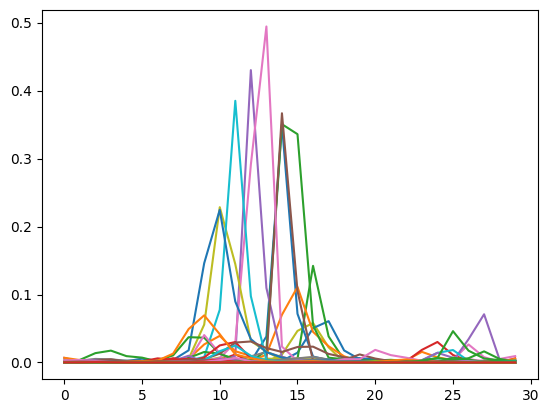

tensor([1])
tensor([[5.1616e-05, 9.9995e-01]], grad_fn=<SoftmaxBackward0>)


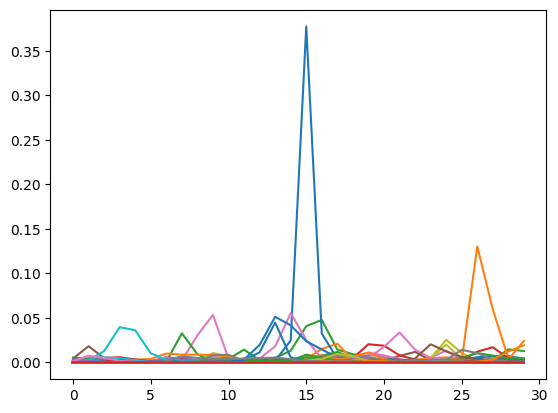

In [172]:
for idx in range(len(detector_dataset)):
    input, label, frame = detector_dataset[idx]
    print(label)
    output = dl_sorter(input)
    output = torch.softmax(output, dim=1)
    print(output)
    detector_dataset.plot_detector_outputs(frame)

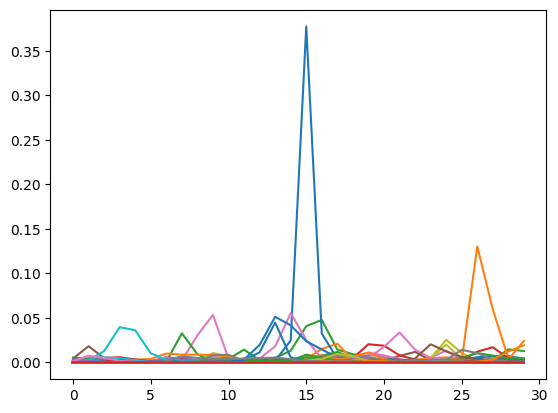

In [92]:
# detector_dataset.plot_detector_outputs(np.random.choice(sorted["spike_times"]))
# detector_dataset.plot_detector_outputs(np.random.choice(detector_dataset.noise_times))
detector_dataset.plot_detector_outputs(detector_dataset.noise_times[0])

In [20]:
sorted = detector_dataset.sorted

In [25]:
print(sorted["units"][0].keys())

dict_keys(['unit_id', 'spike_train', 'x_max', 'y_max', 'template', 'sorted_index', 'max_channel_si', 'max_channel_id', 'peak_sign', 'peak_ind', 'amplitudes', 'std_norms', 'electrode'])


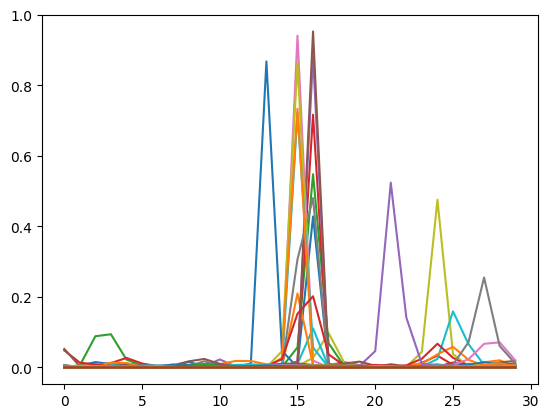

In [84]:
unit = sorted["units"][0]

# temps = unit['template']
# plt.plot(temps)
# plt.show()

st = unit["spike_train"][100]
detector_dataset.plot_detector_outputs(st)